In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt

color_cycle = ["#8491B4FF", "#00A087FF", "#E64B35FF", "#3C5488FF", "#F39B7FFF", "#7E6148FF", "#4DBBD5FF", "#DC0000FF",  "#91D1C2FF", "#B09C85FF", "#923a3aFF", "#70699eFF"]
colors = mpl.cycler(color=color_cycle, alpha=[.9] * len(color_cycle)) 
mpl.rc('axes', grid=True, edgecolor='k', prop_cycle=colors)
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['figure.dpi'] = 100

SMALL_SIZE = 12
MEDIUM_SIZE = 14  #default 10
LARGE_SIZE = 16

plt.rcParams['font.family'] = 'sans-serif'
plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title


In [3]:
import numpy as np
from numpy import kron, sqrt, pi, arccos, cos, sin, exp
from numpy.linalg import norm
from numpy.linalg import matrix_power, eig
from scipy.linalg import expm
from copy import deepcopy
import functools as ft

X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
I = np.array([[1, 0], [0, 1]])

def spectral_norm(U0):
    return np.linalg.norm(U0, ord=2)

def commutator(A, B):
    return A@B - B@A

def local_interaction(n, dict):
    R_list = [I] * n
    for i in dict:
        R_list[i] = dict[i]
    return ft.reduce(kron, R_list)

def neighbor_heisenberg(n_qubit):
    edges = []
    for i in range(n_qubit-1):
        edges.append((i, i+1))    
    XX = np.zeros((2**n_qubit, 2**n_qubit)).astype(np.complex128)
    YY = np.zeros((2**n_qubit, 2**n_qubit)).astype(np.complex128)
    ZZ = np.zeros((2**n_qubit, 2**n_qubit)).astype(np.complex128)
    edges.append((0, n_qubit-1))

    for i, j in edges:
        XX += local_interaction(n_qubit, {i:X, j:X})
        YY += local_interaction(n_qubit, {i:Y, j:Y})
        ZZ += local_interaction(n_qubit, {i:Z, j:Z})
        ZZ += local_interaction(n_qubit, {i:Z, j:I}) * 0.2
    return [XX, YY, ZZ]

def sum_second_order_commutator_norm(H_list):
    sum = 0
    n = len(H_list)
    for gamma_1 in range(n):
        R = np.zeros_like(H_list[0])
        for gamma_3 in range(gamma_1+1, n):
            for gamma_2 in range(gamma_1+1, n):
                R += commutator(H_list[gamma_3], commutator(H_list[gamma_2], H_list[gamma_1])) / 12
        sum += spectral_norm(R)
    for gamma_1 in range(n):
        R = np.zeros_like(H_list[0])
        for gamma_2 in range(gamma_1+1, n):
            R += commutator(H_list[gamma_1], commutator(H_list[gamma_1], H_list[gamma_2])) / 24
        sum += spectral_norm(R)
    return sum

def near_diagonal(R, eigenvalues, eps):
    N = R.shape[0]
    # print(N)
    R_copy = deepcopy(R)
    for i in range(N):
        for j in range(N):
            if abs(eigenvalues[i] - eigenvalues[j]) > eps:
                R_copy[i][j] = 0
    return R_copy

H_tmp = []
def trotter_simulation(H_list, n, T, r):
    U1 = np.eye(2 ** n).astype(np.complex128)
    # print(H_list, T, r)
    for H in H_list:
        H_tmp.append(-1.0j * H * T / r)
        U1 = U1 @ expm(-1.0j * H * T / r)
    return matrix_power(U1, r)

def trotter_error(H_list, n_qubit, T, r):
    U_target = expm(-1.0j* sum(H_list) * T)
    U_impl = trotter_simulation(H_list, n_qubit, T, r)
    return spectral_norm(U_impl - U_target)

def interference_bound_new(R, H, T, eps):
    N = R.shape[0]
    eigenvalues, eigenvectors = eig(H)
    R_norm = spectral_norm(R)
    delta_norm = spectral_norm(near_diagonal(R, eigenvalues, eps)) # eps refers to the spectral gap
    resid_norm = spectral_norm(R-near_diagonal(R, eigenvalues, eps))
    # print(R_norm, delta_norm, resid_norm)
    return (resid_norm * min(1, (1 / (eps * T))) + delta_norm) 

{100: 1.9999987602989466, 127: 1.9999896898906084, 161: 1.9864831336122146, 204: 1.9329677589662007, 259: 1.6009237094142805, 329: 1.1760215818798374, 418: 0.819344328591606, 530: 0.5638167839614806, 672: 0.38988826107316, 853: 0.27353137070369543, 1083: 0.20449372187079032, 1374: 0.1570546352923162, 1743: 0.12154657856772191, 2212: 0.09454531590940227, 2807: 0.07383595261521855, 3562: 0.0578206627130167, 4520: 0.045364912332122295, 5736: 0.03563620690741454, 7279: 0.028019384240473923, 9237: 0.022044408588399837, 11721: 0.017352134943579973, 14874: 0.013661924119720786, 18874: 0.010759546845110457, 23950: 0.008475014466819017, 30392: 0.006676147430089505, 38566: 0.005259662180506871, 48939: 0.004143936288219728, 62102: 0.0032650497178518664, 78805: 0.0025726767102667307, 100000: 0.0020271931838379462} {100: 2, 127: 2, 161: 2, 204: 2, 259: 2, 329: 2, 418: 2, 530: 2, 672: 2, 853: 2, 1083: 2, 1374: 2, 1743: 2, 2212: 2, 2807: 2, 3562: 2, 4520: 2, 5736: 2, 7279: 2, 9237: 1.6494967784272598

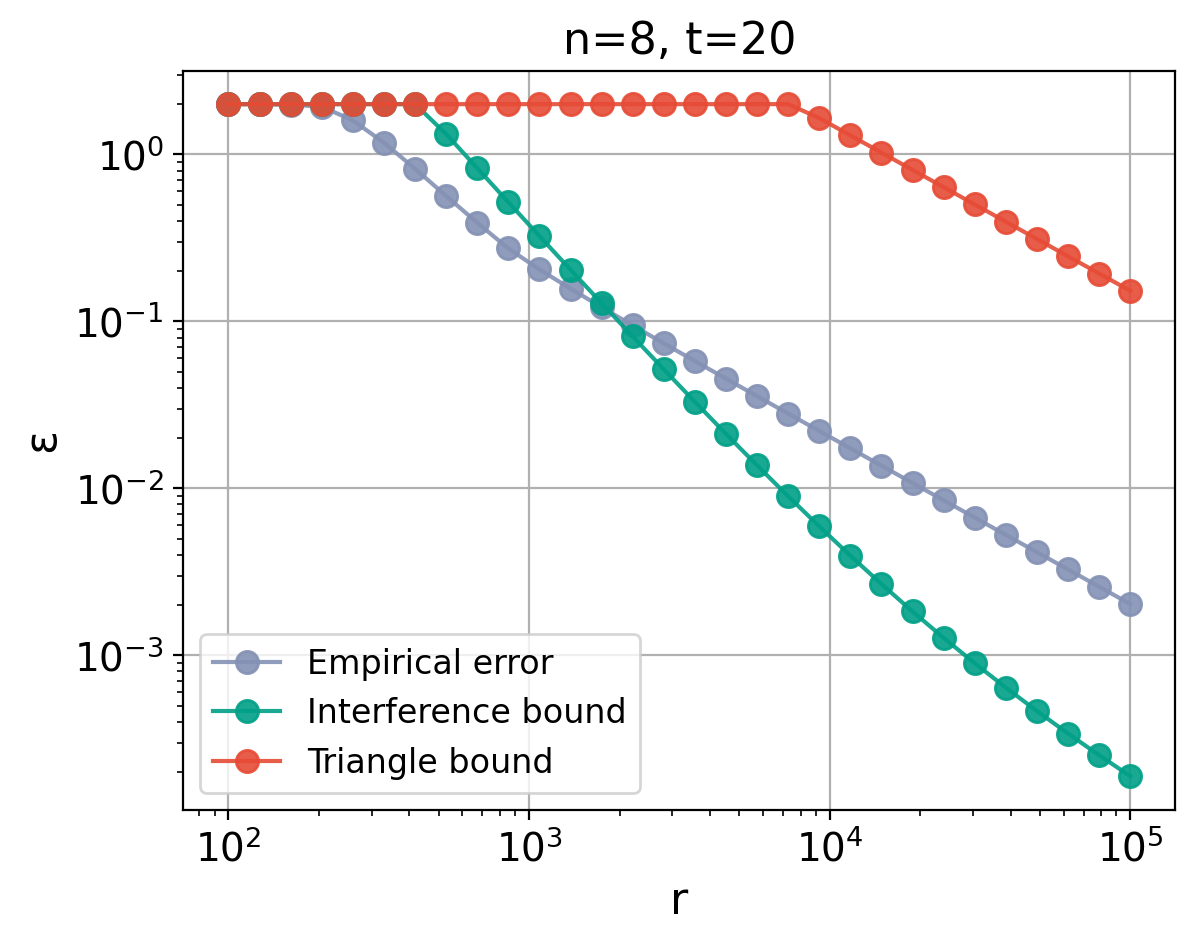

In [6]:

fig, ax = plt.subplots()
n = 8
H_list = neighbor_heisenberg(n)
H = sum(H_list)
R = commutator(H_list[0], H_list[1]) + commutator(H_list[0], H_list[2]) + commutator(H_list[1], H_list[2])
R2 = sum_second_order_commutator_norm(H_list)

T = 20
# T = 2 * n
eps = 0.001

emepricial_error = {}
interference_bound = {}
triangle_bound = {}

# logspace_seq = r_list = sorted(list(set(np.logspace(2, 5, 30, dtype=int))))
r_num = 30
logspace_seq = np.logspace(2, 5, num = 30)
# logspace_seq = np.logspace(3, 9, num = 20)

for i in range(r_num):
    r = round(logspace_seq[i])
    # emepricial_error[r] = spectral_norm(expm(-1.0j * H* T - T*T/r * 0.5 * R) - expm(-1.0j * H * T))
    emepricial_error[r] = trotter_error(H_list, n, T, r)
    interference_bound[r] = min(2, interference_bound_new(R, H, T, eps) * eps * T*T/r + R2 * T*T*T/(r*r))
    triangle_bound[r] = min(2, spectral_norm(R) * T*T/r)
# print(interference_bound_new(R, H, t, eps))
print(emepricial_error, triangle_bound)
title = f"n=8, t={T}"
x_label = "r"
y_label = "ε"
y_title = "Empirical error"
y1_title = "Interference bound"
y2_title = "Triangle bound"
x_list = []
y_list = []
y1_list = []
y2_list = []
for r in emepricial_error:
    y_list.append((emepricial_error[r]))
    x_list.append(r)
    y1_list.append(interference_bound[r])
    y2_list.append(triangle_bound[r])
ax.plot(x_list, y_list, marker="o", label = y_title)
ax.plot(x_list, y1_list, marker="o", label = y1_title)
ax.plot(x_list, y2_list, marker="o", label = y2_title)
ax.set_title(title)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(loc = "best")